# Plankton Classification

In [63]:
import os
from glob import glob
import random
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from termcolor import cprint

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as transforms
from torch.utils.data import Dataset, DataLoader

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.backends.cudnn.benchmark = True  # Code for accelerating GPU operations

In [3]:
class_name = []
class_count = []

for name in os.listdir("E:/data/datasciencebowl/train"):
    class_name.append(name)
    class_count.append(
        len(os.listdir(f"E:/data/datasciencebowl/train/{name}")))

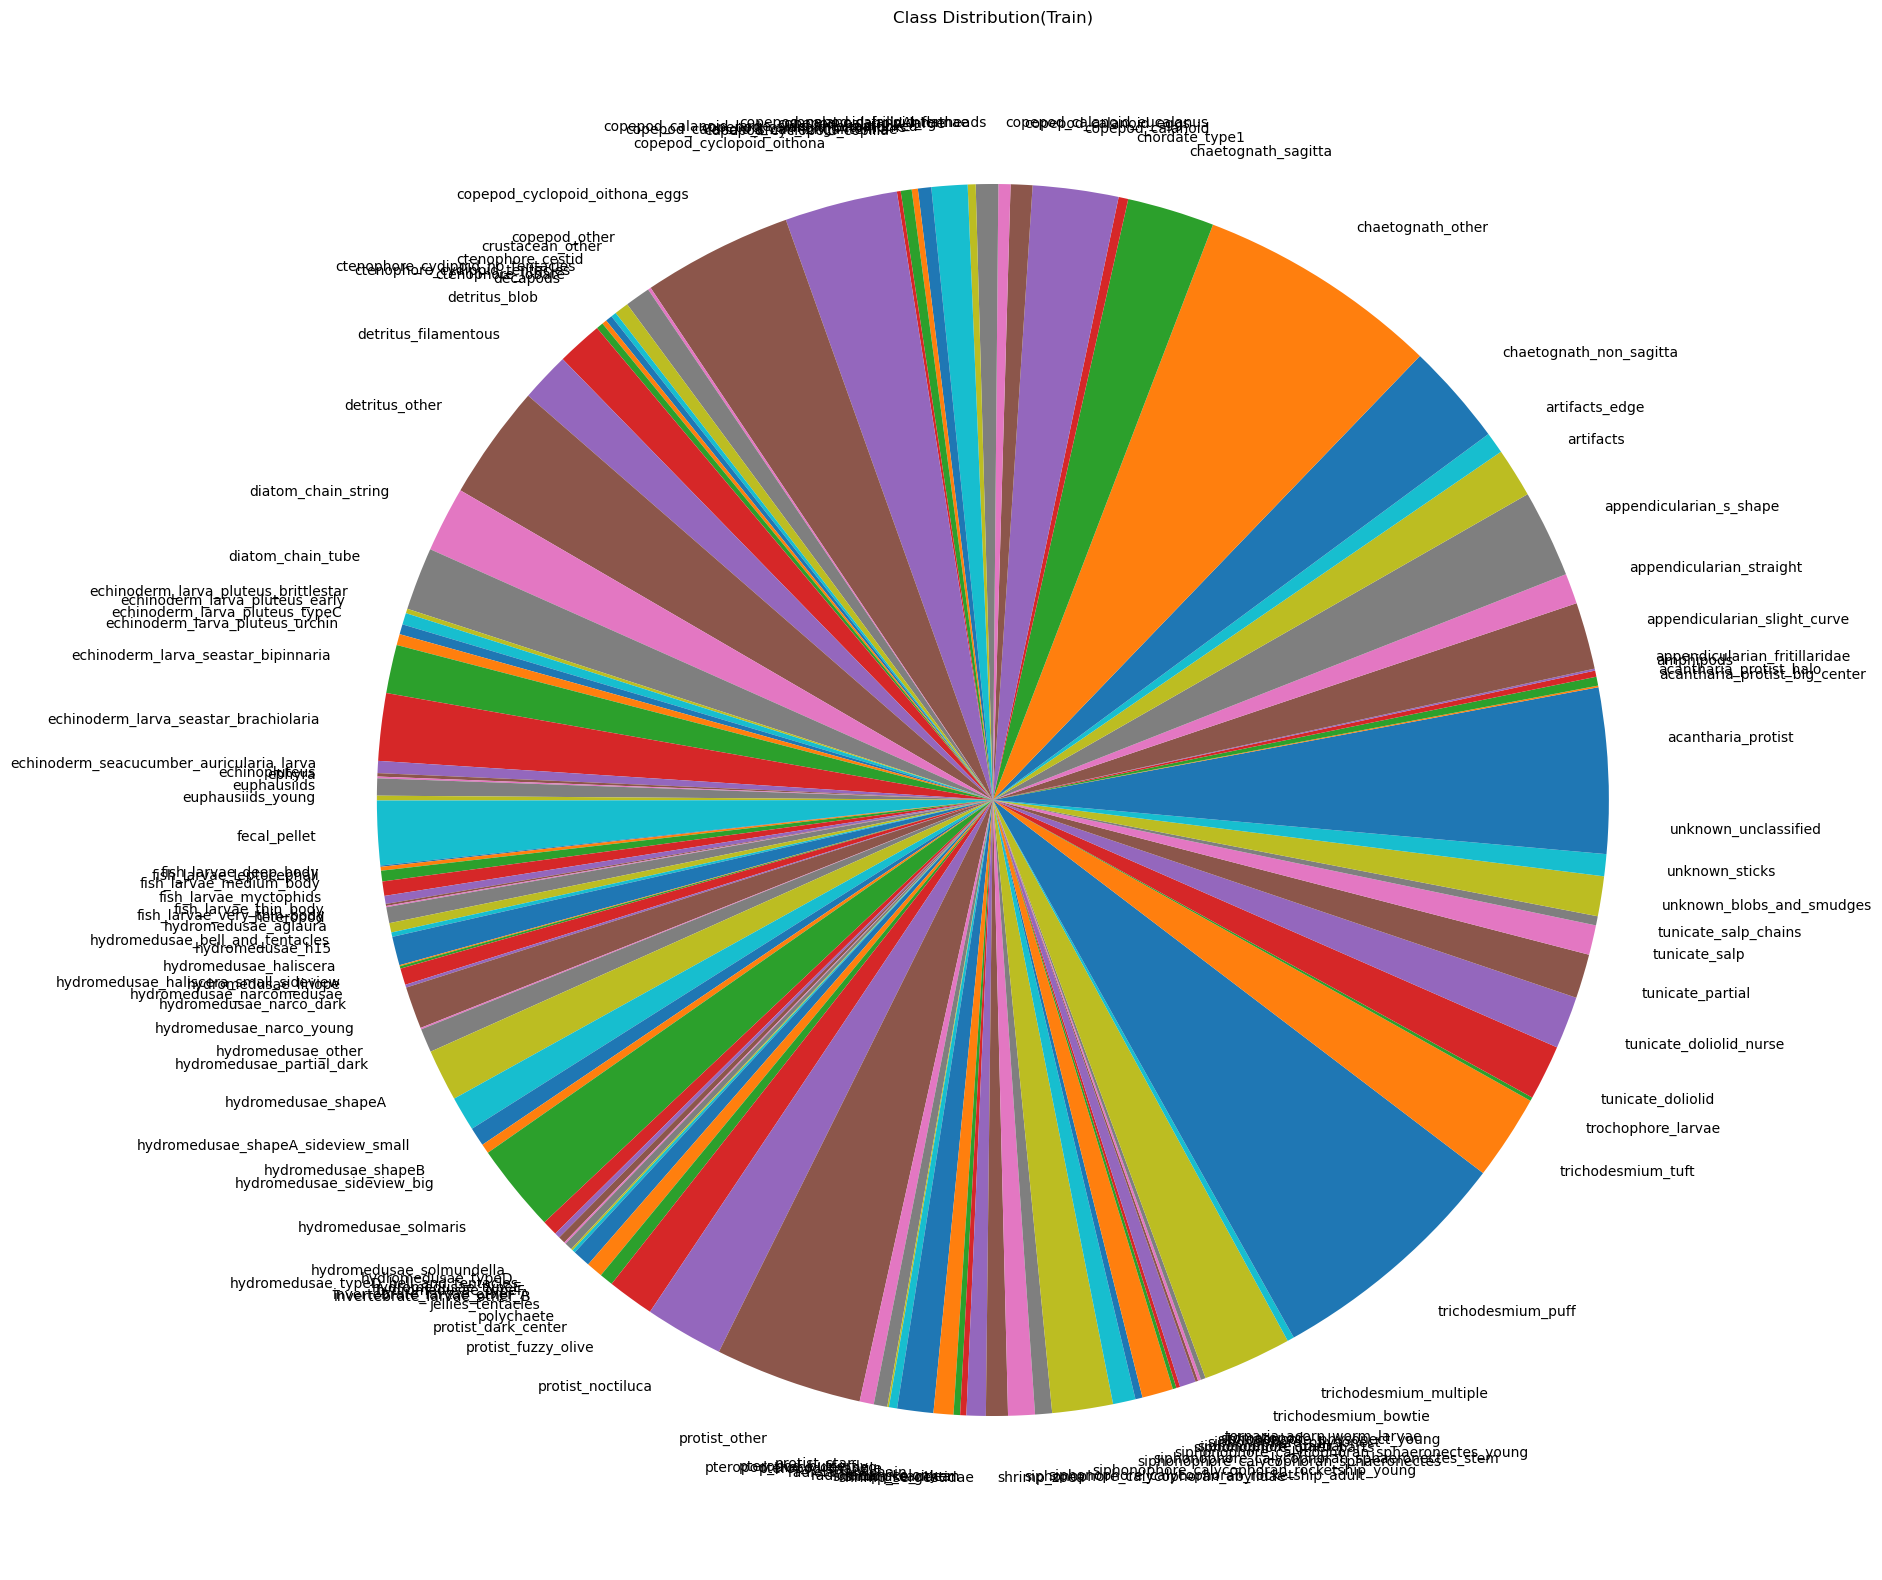

In [4]:
plt.figure(figsize=(20, 20))
colors = sns.color_palette('pastel')[0:len(class_name)]
plt.pie(class_count, labels=class_name)
plt.title('Class Distribution(Train)')
plt.show()

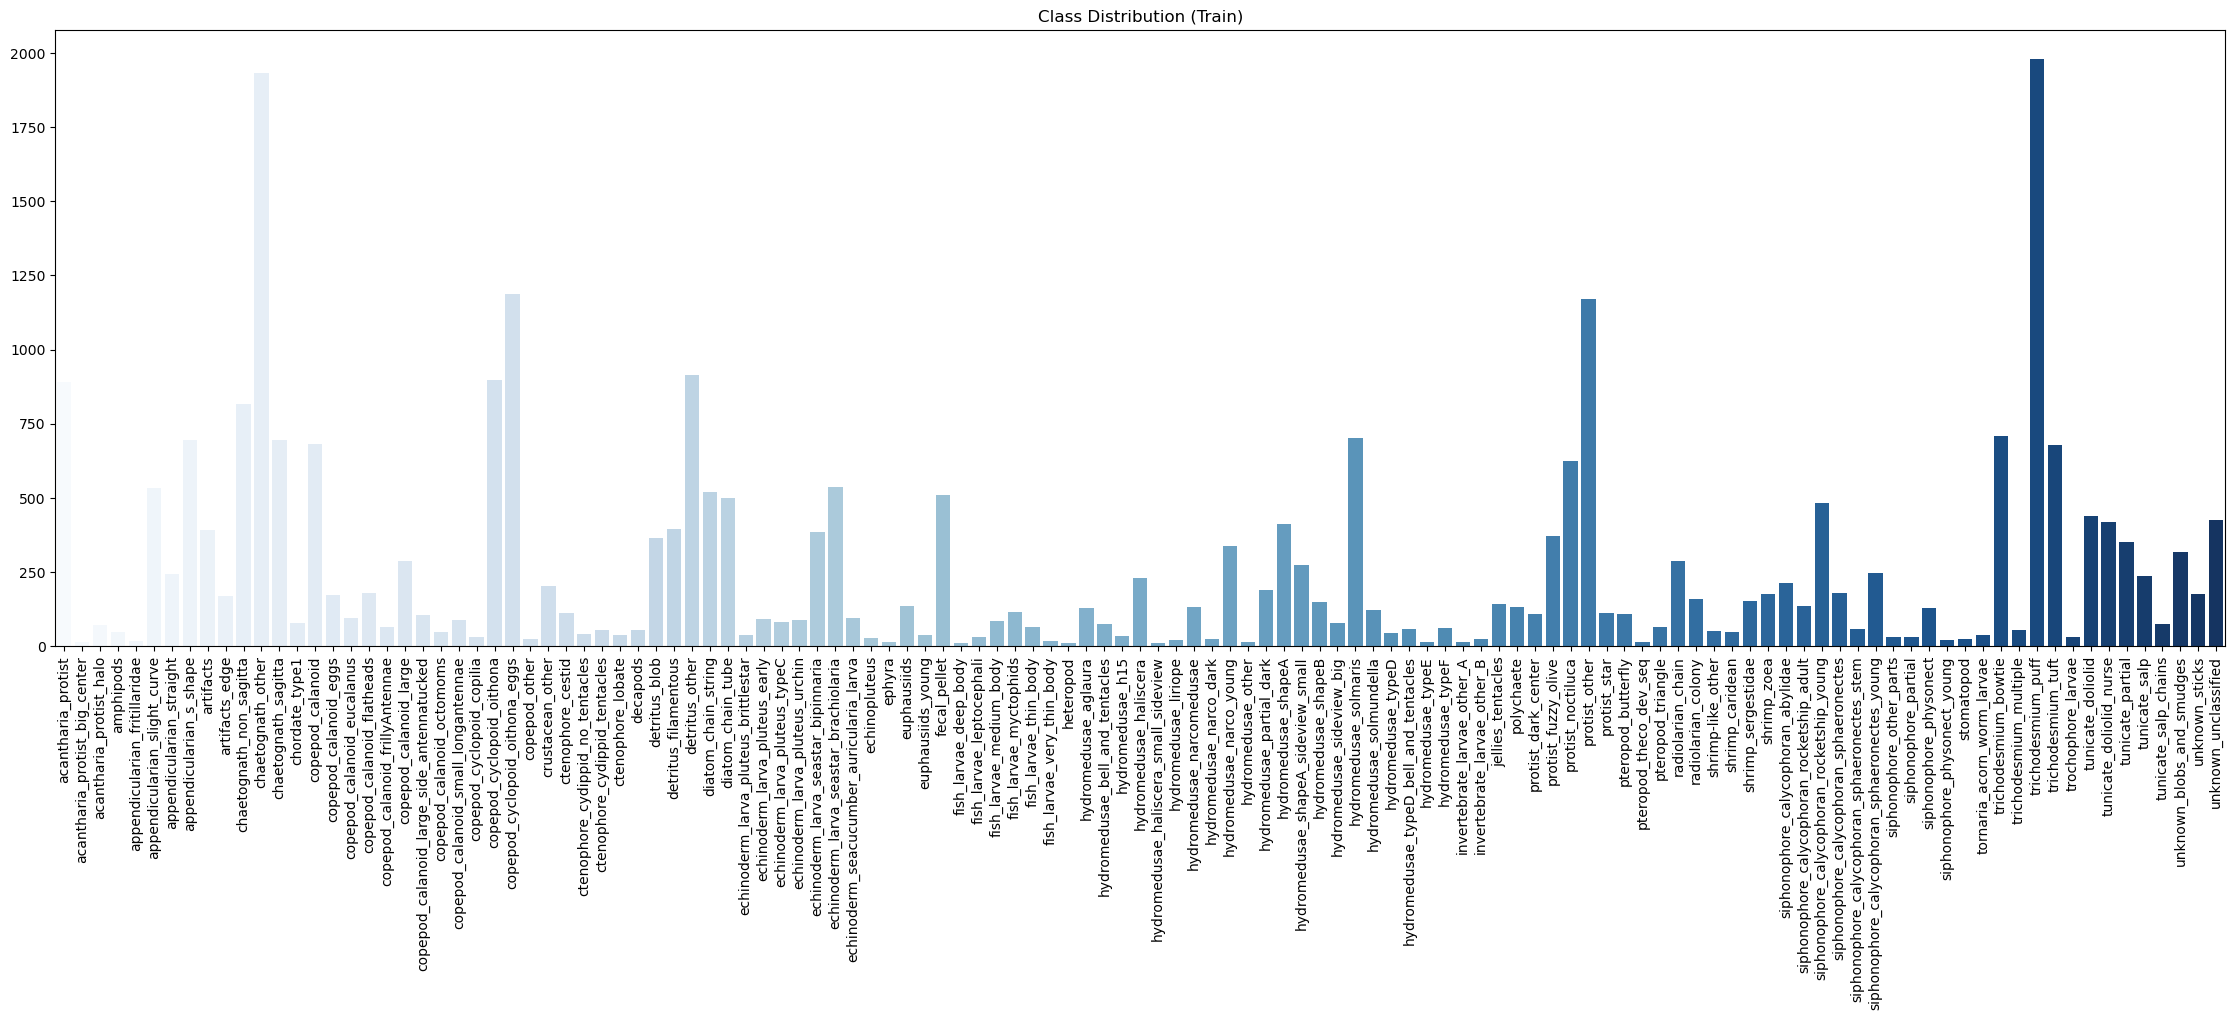

In [6]:
plt.figure(figsize=(28, 8))
sns.barplot(x=class_name, y=class_count, palette='Blues')
plt.title('Class Distribution (Train)')
plt.xticks(rotation=90)
plt.show()

## Dataset Generation

In [20]:
def generare_csv(root, train=True, img_ext='jpg'):
    df = pd.DataFrame(columns=['path', 'class'])
    if train:
        for index, label in enumerate(os.listdir(root)):
            links = glob(f"{root}/{label}/*{img_ext}")
            temp_df = pd.DataFrame(
                {'path': links, 'class': np.ones(len(links), dtype='float32')*index})
            df = pd.concat([df, temp_df], axis=0)
    else:
        links = glob(f"{root}/*{img_ext}")
        temp_df = pd.DataFrame(
            {'path': links, 'class': np.ones(len(links), dtype='float32')})
        df = pd.concat([df, temp_df], axis=0)

    return df

In [21]:
train_csv = generare_csv("E:/data/datasciencebowl/train")
train_csv.head()

,path,class
0,E:/data/datasciencebowl/train/acantharia_proti...,0.0
1,E:/data/datasciencebowl/train/acantharia_proti...,0.0
2,E:/data/datasciencebowl/train/acantharia_proti...,0.0
3,E:/data/datasciencebowl/train/acantharia_proti...,0.0
4,E:/data/datasciencebowl/train/acantharia_proti...,0.0


In [22]:
test_csv = generare_csv("E:/data/datasciencebowl/test", train=False)
test_csv.head()

,path,class
0,E:/data/datasciencebowl/test\1.jpg,1.0
1,E:/data/datasciencebowl/test\10.jpg,1.0
2,E:/data/datasciencebowl/test\100.jpg,1.0
3,E:/data/datasciencebowl/test\1000.jpg,1.0
4,E:/data/datasciencebowl/test\10000.jpg,1.0


In [ ]:
def load_image(path, H, W):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W))
    return img

In [23]:
transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [24]:
class PlanktonDataset(Dataset):
    def __init__(self, df, H=128, W=128, transform=None):
        super().__init__()
        self.df = df
        self.H = H
        self.W = W
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        path = self.df.iloc[index, 0]
        img = load_image(path, H=self.H, W=self.W)
        label = self.df.iloc[index, 1]
        img = Image.fromarray(img)
        if self.transform != None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return (img, (label, path))

In [25]:
train_ds = PlanktonDataset(train_csv, 128, 128, transform=transform)
test_ds = PlanktonDataset(test_csv, 128, 128)

In [26]:
img, label = test_ds.__getitem__(3)
img.shape, label[0], label[1]

(torch.Size([3, 128, 128]), 1.0, 'E:/data/datasciencebowl/test\\1000.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


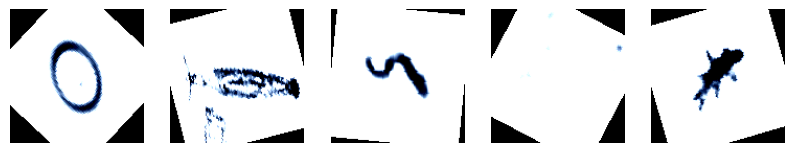

In [27]:
# Let each data set display 5 images at random
def plotsample(data):  # 只能够接受tensor格式的图像
    fig, axs = plt.subplots(1, 5, figsize=(10, 10))  # 建立子图
    for i in range(5):
        num = random.randint(0, len(data)-1)  # 首先选取随机数，随机选取五次
        # 抽取数据中对应的图像对象，make_grid函数可将任意格式的图像的通道数升为3，而不改变图像原始的数据
        # 而展示图像用的imshow函数最常见的输入格式也是3通道
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1]  # 提取标签
        # 将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        # axs[i].set_title(nplabel)  # 给每个子图加上标签
        axs[i].axis("off")  # 消除每个子图的坐标轴


plotsample(train_ds)

In [28]:
spl_idx = int(train_ds.__len__()*0.75)
train_ds, val_ds = torch.utils.data.random_split(
    train_ds, [spl_idx, train_ds.__len__()-spl_idx])

In [29]:
print(f"Size of train dataset : {train_ds.__len__()}")
print(f"Size of validation dataset : {val_ds.__len__()}")
print(f"Size of test dataset : {test_ds.__len__()}")

Size of train dataset : 22752
Size of validation dataset : 7584
Size of test dataset : 130400


In [30]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Model Generation

In [44]:
class Conv(nn.Module):
    def __init__(self, in_features, out_features, kerel_size=3, stride=1, padding=0):
        super(Conv, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_features, out_features, kerel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_features),
        )

    def forward(self, x):
        return self.seq(x)


class PlankNet(nn.Module):
    def __init__(self, in_features, out_features, H=128, W=128):
        super(PlankNet, self).__init__()
        self.model = nn.Sequential(
            Conv(in_features, 16, 4),
            nn.MaxPool2d(2),
            Conv(16, 32, 3),
            Conv(32, 64, 3),
            nn.Dropout(0.1),
            nn.MaxPool2d(2),
            Conv(64, 128),
            nn.Dropout(0.2),
            Conv(128, 64, 3),
            Conv(64, 32, 3),
            nn.Flatten(),
            nn.Linear(32*23*23, 4096),
            nn.Linear(4096, out_features),
        )

    def forward(self, x):
        return self.model(x)

In [47]:
out_features = len(class_name)
model = PlankNet(3, out_features, 128, 128)

In [48]:
# check
rand_data = torch.rand(1, 3, 128, 128)
print(model(rand_data).shape)

torch.Size([1, 121])


In [49]:
print(model)

PlankNet(
  (model): Sequential(
    (0): Conv(
      (seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv(
      (seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Conv(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 128, ke

## Train

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [79]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)

train_loss = []
val_loss = []

model = model.to(device)
best_loss = np.inf
for epoch in range(epochs):
    print(f'Epoch{epoch+1} : \n')
    tr_loss = 0.
    Val_loss = 0.
    model.train()

    for index, (train_path, (label, _)) in enumerate(train_dl):
        optim.zero_grad()
        train_path, label = train_path.to(device), label.long().to(device)
        yhat = model(train_path)
        tloss = criterion(yhat, label)
        tr_loss += tloss.item()
        train_loss.append(tloss.item())
        tloss.backward()
        optim.step()

        if index % 100 == 99:
            print(f"      Step{index+1} Loss : {'%4f'%(tloss.item())}")

    model.eval()
    with torch.no_grad():
        for index, (val_path, (label, _)) in enumerate(val_dl):
            val_path, label = val_path.to(device), label.long().to(device)
            yhat = model(val_path)
            vloss = criterion(yhat, label)
            Val_loss += vloss.item()
            val_loss.append(vloss.item())
    print(
        f"\n     Training Loss : {'%.4f'%(tr_loss)}  ||  Validation Loss : {'%.4f'%(Val_loss)}\n")

    if Val_loss < best_loss:
        print("Model updation: Success!\n")
        torch.save(model, 'best_model.pth')
        best_loss = Val_loss
    else:
        print("Model updation: Failed!!!!!\n")

print('Training completed...')

Epoch1 : 

      Step100 Loss : 2.050105
      Step200 Loss : 2.233495
      Step300 Loss : 1.890447

     Training Loss : 706.6419  ||  Validation Loss : 365.9966

Model updation: Success!

Epoch2 : 

      Step100 Loss : 1.371572
      Step200 Loss : 2.023735
      Step300 Loss : 1.251297

     Training Loss : 634.2300  ||  Validation Loss : 318.2329

Model updation: Success!

Epoch3 : 

      Step100 Loss : 1.526293
      Step200 Loss : 1.937992
      Step300 Loss : 1.267218

     Training Loss : 601.3381  ||  Validation Loss : 430.9440

Model updation: Failed!!!!!

Epoch4 : 

      Step100 Loss : 1.755636
      Step200 Loss : 2.216769
      Step300 Loss : 2.115471

     Training Loss : 568.3624  ||  Validation Loss : 424.2698

Model updation: Failed!!!!!

Epoch5 : 

      Step100 Loss : 1.740389
      Step200 Loss : 1.213518
      Step300 Loss : 1.526689

     Training Loss : 545.4568  ||  Validation Loss : 329.3957

Model updation: Failed!!!!!

Epoch6 : 

      Step100 Loss : 1.18

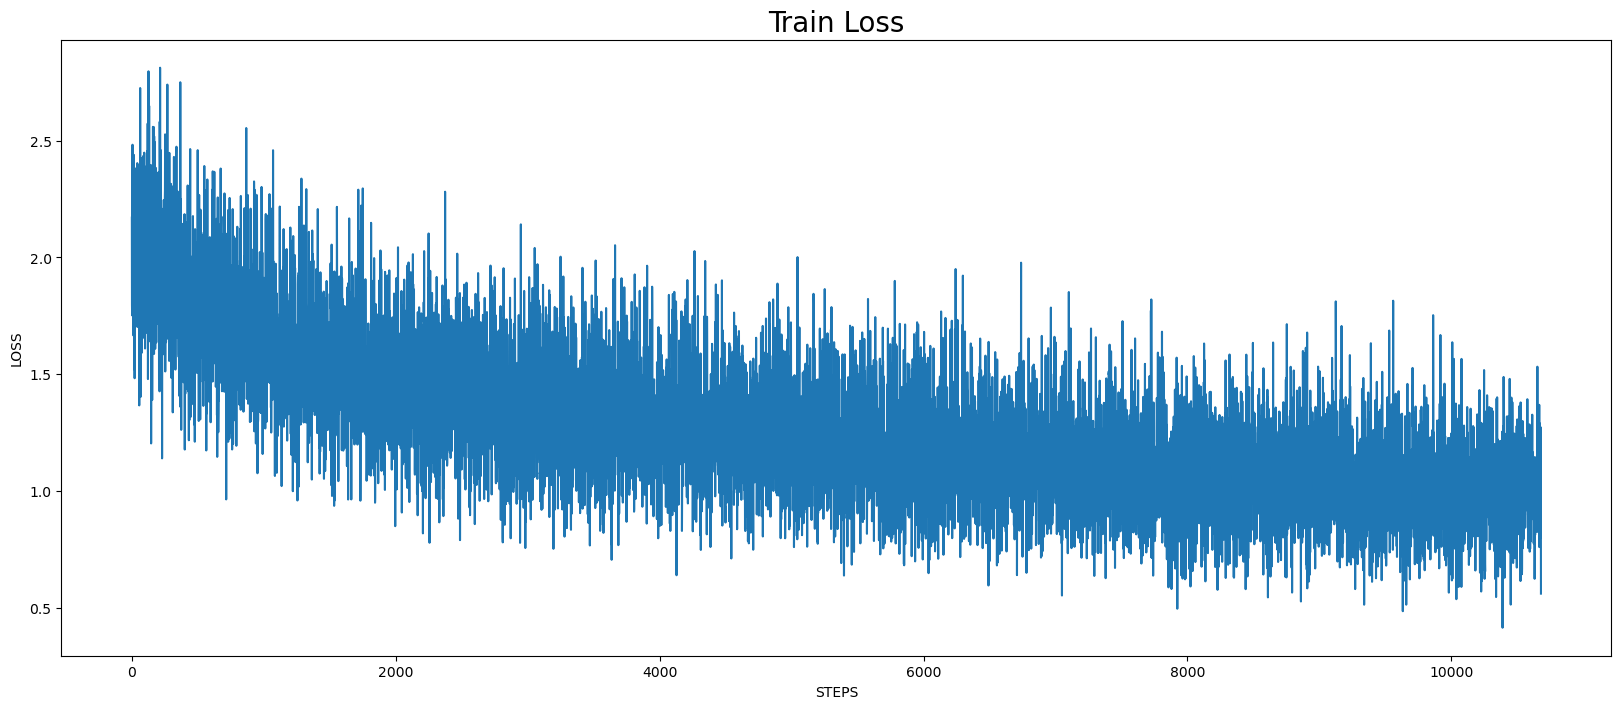

In [80]:
plt.figure(figsize=(20, 8))
plt.plot(train_loss)
plt.title('Train Loss', size=20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

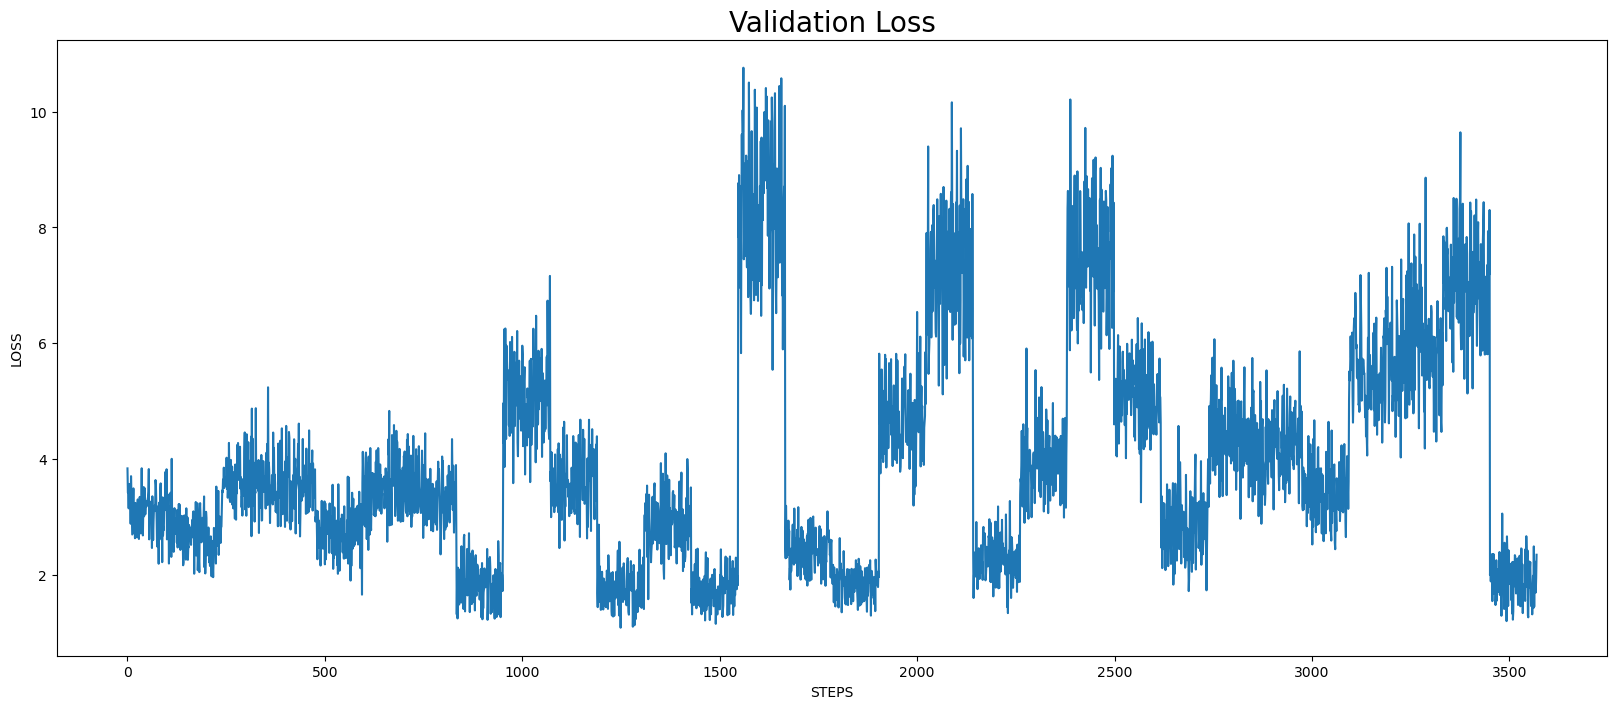

In [81]:
plt.figure(figsize=(20, 8))
plt.plot(val_loss)
plt.title('Validation Loss', size=20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

In [82]:
%pwd

'C:\\Users\\WenBi\\Desktop\\Project\\kaggle'

In [83]:
best_model = torch.load('best_model.pth')

In [84]:
best_model

PlankNet(
  (model): Sequential(
    (0): Conv(
      (seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv(
      (seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Conv(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv(
      (seq): Sequential(
        (0): Conv2d(64, 128, ke

In [134]:
def preprocess_names(names_list):
    name_list = []
    for name in names_list:
        name_list.append(name.split('\\')[-1])
    return name_list

In [135]:
def create_submission_file(test_dataloader, model, class_names):
    df = pd.DataFrame()
    model.eval()
    sf_layer = nn.Softmax(dim=1)
    with torch.no_grad():
        for index, (test_patch, attr) in enumerate(test_dataloader):  # loading test data
            paths = preprocess_names(attr[1])
            test_patch = test_patch.cuda()
            op = model(test_patch)
            op = sf_layer(op)
            paths = np.array(list(paths))  # adding the filenames in a list
            op = op.cpu().detach().numpy()
            # creating the patch dataframe
            patch_df = pd.DataFrame(op, columns=class_names)
            patch_df.insert(0, 'image', paths)
            # joining the patch dataframe with the main one.
            df = pd.concat([df, patch_df], axis=0)

            if index % 100 == 99:
                print(f"{index + 1} Steps Completed...\n")
    print('Test Dataframe Generated...\n')

    return df

In [136]:
best_model = best_model.cuda()
pred_df = create_submission_file(test_dl, best_model, class_name)
pred_df.head()

100 Steps Completed...

200 Steps Completed...

300 Steps Completed...

400 Steps Completed...

500 Steps Completed...

600 Steps Completed...

700 Steps Completed...

800 Steps Completed...

900 Steps Completed...

1000 Steps Completed...

1100 Steps Completed...

1200 Steps Completed...

1300 Steps Completed...

1400 Steps Completed...

1500 Steps Completed...

1600 Steps Completed...

1700 Steps Completed...

1800 Steps Completed...

1900 Steps Completed...

2000 Steps Completed...

Test Dataframe Generated...



,image,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_slight_curve,appendicularian_straight,appendicularian_s_shape,artifacts,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,1.115018e-04,1.525299e-08,4.250677e-07,3.421132e-05,1.088728e-05,1.925468e-03,1.967615e-03,1.422866e-03,2.033486e-03,...,7.266963e-03,5.398518e-07,2.330272e-04,9.347345e-04,1.358765e-06,9.099358e-07,1.979085e-06,2.220781e-02,3.737296e-02,7.232808e-04
1,10.jpg,3.842057e-05,1.840567e-07,1.705937e-05,1.289437e-04,1.521127e-07,3.548517e-05,1.462379e-05,2.709314e-05,1.655809e-06,...,9.051196e-04,4.228404e-07,2.650850e-04,7.030384e-06,1.033636e-08,1.451221e-06,4.206345e-08,2.051017e-02,1.220258e-03,1.360313e-03
2,100.jpg,3.135111e-14,5.929020e-16,4.804730e-12,2.491913e-13,8.001496e-14,2.320901e-11,2.052408e-14,9.485548e-11,4.714240e-17,...,1.903954e-18,1.013098e-16,4.456246e-11,7.704871e-12,2.334516e-08,1.208262e-10,1.734541e-19,4.143893e-13,9.069698e-15,2.481398e-09
3,1000.jpg,1.972420e-05,4.168964e-07,1.363118e-06,3.854974e-04,1.226532e-03,6.609764e-05,8.413178e-06,6.228775e-04,8.044357e-06,...,6.742245e-03,3.057842e-08,7.366948e-05,5.035651e-05,2.962684e-07,2.394465e-06,2.254106e-07,5.721984e-03,1.211062e-02,9.285253e-04
4,10000.jpg,6.154249e-11,3.039865e-11,8.636402e-13,3.981272e-08,3.118838e-16,3.165721e-14,5.187792e-13,4.881438e-15,6.931184e-13,...,2.195234e-05,7.779714e-15,3.019909e-11,8.440509e-13,1.329991e-14,4.381527e-13,2.164387e-14,7.573071e-07,1.245809e-09,2.445916e-10


In [137]:
# Checking if all the imae names are different
assert pred_df['image'].nunique(
) == pred_df.shape[0], " Submission format not correct!"
print('Submission correcty created !')

Submission correcty created !


In [138]:
pred_df.to_csv('submission.csv', index=False)